## Greate plot referece
Great plot references:
https://matplotlib.org/api/_as_gen/matplotlib.pyplot.xlabel.html
https://matplotlib.org/api/_as_gen/matplotlib.pyplot.text.html

Model comparison:
https://docs.pymc.io/notebooks/model_comparison.html

### Quesitons to Chris:
1. What model is better the one with a lot of:
There were 283 divergences after tuning. Increase `target_accept` or reparameterize, but low AIC

or the one with:

There were 2 divergences after tuning. Increase `target_accept` or reparameterize
and a higher AIC

1. What does this mean:

The estimated number of effective samples is smaller than 200 for some parameters.

1. How to figure out what parameter is this and what is the effective sample size for it?

### Some sites that Chris has recommended:
1. colab.research.google.com
1. jupyter.accre.vanderbilt.edu
1. bit.ly/drug_trial_data
1. anaconda.com/download

### How to install stuff:
1. conda install pymc3
1. pip install pymc3

When you run system commands from a notebook, you have to add an exclamation mark: !pip install pymc3


## Import all the packages

In [18]:
%matplotlib inline
import numpy as np
import seaborn as sns; sns.set_context('notebook')

import pymc3 as pm3
import matplotlib.pyplot as plt
import pandas

from IPython.display import Latex


RANDOM_SEEDS = [5142018, 3211968]

In [19]:
pydata = pandas.read_csv("/Users/svetlanaeden/stuff/StatStuff/OSCAR_STUFF/pydata.csv")

ACTORS = True         ### set False to analyze Best Actress
MAIN_ANALYSIS = False ### set False for sensitivity analysis

if ACTORS:
    categ = "ACTOR IN A LEADING ROLE"
    bNominVar = 'bActorNomin'
    if MAIN_ANALYSIS:
        bWonVar = 'bActorWonAsOne'
        plotFileName = 'plot_main_men.pdf'
    else:
        bWonVar = 'bActorWon'
        plotFileName = 'plot_sens_men.pdf'
else:
    categ = "ACTRESS IN A LEADING ROLE"
    bNominVar = 'bActressNomin'
    if MAIN_ANALYSIS:
        bWonVar = 'bActressWonAsOne'
        plotFileName = 'plot_main_wom.pdf'
    else:
        bWonVar = 'bActressWon'
        plotFileName = 'plot_sens_wom.pdf'

### subset the data
subdata = pydata.loc[pydata['categ'] == categ, ["movie", "name", "year", "movieAndYear", bNominVar, bWonVar, "bPNomin"]]
subdata['nominBABP'] = subdata[bNominVar] * subdata.bPNomin
subdata['wonBAgivenBP'] = subdata[bWonVar] * subdata.bPNomin
subdata = subdata.drop(['bPNomin', 'name'], axis=1)

if MAIN_ANALYSIS:
     subdata = subdata.drop_duplicates()

subdata.loc[6:12,]
subdata.shape

(421, 7)

In [20]:
### process data by year: find how many BA nomim. were in a  year
###     find how many BA-BP nominations were in a year
### find the 'pattern' BA-BP out of all BA
subdataGroupedByYear = subdata.groupby(subdata.year)
dataGroupedByYear = subdataGroupedByYear.agg(np.sum)
tmp1 = [str(x) for x in dataGroupedByYear['nominBABP'].values]
tmp2 = [str(x) for x in dataGroupedByYear[bNominVar].values]
tmp3 = [tmp1[i] + ',' + tmp2[i] for i in range(dataGroupedByYear.shape[0])]
dataGroupedByYear = dataGroupedByYear.assign(pattern = tmp3)
dataGroupedByYear[bWonVar].value_counts()
# dataGroupedByYear.head()

1    85
Name: bActorWon, dtype: int64

In [21]:
### process data by pattern
byPattern = dataGroupedByYear.groupby(dataGroupedByYear.pattern)
groups = byPattern.groups
groups
byPattern.get_group('4,5')

,bActorNomin,bActorWon,nominBABP,wonBAgivenBP,pattern
year,,,,,
1935,5,1,4,1,"4,5"
1936,5,1,4,1,"4,5"
1939,5,1,4,1,"4,5"
1940,5,1,4,1,"4,5"
1944,5,1,4,1,"4,5"
1946,5,1,4,1,"4,5"
1953,5,1,4,0,"4,5"
1958,5,1,4,1,"4,5"
1961,5,1,4,1,"4,5"


In [22]:
data1 = byPattern.agg(np.sum)
data1 = data1.drop(['nominBABP', bNominVar, bWonVar],  axis = 1)
data2 = byPattern.agg(len)
data2 = data2.drop(['nominBABP', 'wonBAgivenBP', bWonVar],  axis = 1)
### join number of patterns and numer of wins by BA-BP
data3 = data1.join(data2)
data3

,wonBAgivenBP,bActorNomin
pattern,,
"0,5",0,1
"1,5",2,8
"2,3",2,2
"2,5",18,24
"3,5",24,27
"4,5",17,18
"5,5",5,5


In [23]:
### keep data with numbers of BA per year and number of nominations BA-BP per year
tmpdata = dataGroupedByYear
tmpdata = tmpdata.drop(['wonBAgivenBP', bWonVar], axis = 1)
tmpdata = tmpdata.drop_duplicates()
tmpdata = tmpdata.set_index('pattern')
tmpdata.columns = ['denom', 'numer']
tmpdata
### join the variables necessary for exp and obs probabilities.
finaldata = tmpdata.join(data3)
finaldata = finaldata.assign(expProb = finaldata['numer']/finaldata['denom'])
finaldata = finaldata.assign(obsProb = finaldata['wonBAgivenBP']/finaldata[bNominVar])
### exclude years when either none or all movies were nominated for BP
finaldata = finaldata[finaldata.denom != finaldata.numer]
finaldata = finaldata[finaldata.numer != 0]
finaldata = finaldata.sort_values(by=['expProb'])
finaldata

,denom,numer,wonBAgivenBP,bActorNomin,expProb,obsProb
pattern,,,,,,
"1,5",5,1,2,8,0.200000,0.250000
"2,5",5,2,18,24,0.400000,0.750000
"3,5",5,3,24,27,0.600000,0.888889
"2,3",3,2,2,2,0.666667,1.000000
"4,5",5,4,17,18,0.800000,0.944444


Create a new variable, a list of unique years

In [24]:
#### unique patterns:
numOfPattern = finaldata.shape[0]
numOfPattern
n_j = finaldata['denom'].values
r_j = finaldata['numer'].values
N_j = finaldata[bNominVar].values
R_j = finaldata['wonBAgivenBP'].values
observProbs = finaldata['obsProb'].values
expectProbs = finaldata['expProb'].values
[R_j, r_j]

[array([ 2, 18, 24,  2, 17]), array([1, 2, 3, 2, 4])]

In [25]:
[N_j, n_j]

[array([ 8, 24, 27,  2, 18]), array([5, 5, 5, 3, 5])]

# Define the Models


Let's code up the model:

### Model I
\begin{eqnarray}
R_j &\sim Binomial(\theta_j, N_j)\\
\theta_j &\sim Beta(\alpha, \beta)\\
\alpha &\sim Gamma(2, 1),~with~mean~2\\
\beta &\sim Gamma(2, 1),~with~mean~2\\
\end{eqnarray}

In [141]:
### this is a binomial model with theta modeled as beta distribution
with pm3.Model() as model_I:

    # Logit-linear model parameters
    alpha1 = pm3.Gamma('alpha1', alpha = 1, beta = 10)
    beta1 = pm3.Gamma('beta1', alpha = 1, beta = 10)
    theta_j = pm3.Beta('theta_j', alpha = alpha1, beta = beta1, shape = expectProbs.shape[0])
    mu = pm3.Deterministic("mu", alpha1/(alpha1 + beta1))   
    # Data likelihood
    y_like = pm3.Binomial('y_like', p = theta_j, n = N_j, observed = R_j)

In [143]:
with model_I:
#     model_I_trace = pm3.sample(4000, tune = 5000, njobs=2, nuts_kwargs=dict(target_accept=0.99), random_seed=RANDOM_SEEDS)
    model_I_trace = pm3.sample(1000, njobs=2, random_seed=RANDOM_SEEDS)

Sampling 2 chains: 100%|██████████| 3000/3000 [00:03<00:00, 935.91draws/s] 


### Model II
\begin{eqnarray}
R_j &\sim Binomial\left(\theta_j, N_j \right)\\
\theta_j &=\frac{1}{1+e^{- \alpha_j}},~\text{where}\\
\alpha_j &\sim N(\mu, \tau)\\
\mu &\sim N(0, sd=100)\\
\tau &\sim Gamma(100, rate=100)\\
\end{eqnarray}

In [156]:
### this is a binomial model with theta modeled as inv.logit with -alpha
with pm3.Model() as model_II:
    
    mu_alpha = pm3.Normal('mu_alpha', 0, sd=100)
    tau_alpha = pm3.HalfCauchy('tau_alpha', 10)
    alpha_j = pm3.Normal('alpha_j', mu_alpha, sd=tau_alpha, shape = numOfPattern)
    theta_j = pm3.Deterministic("theta_j", 1/(1 + np.exp(- alpha_j)))
    mu = pm3.Deterministic("mu", 1/(1 + np.exp(- mu_alpha)))   
    # Data likelihood
    y_like = pm3.Binomial('y_like', p = theta_j, n = N_j, observed = R_j)

In [157]:
with model_II:
#     model_II_trace = pm3.sample(1000, tune = 10000, njobs=2, random_seed=RANDOM_SEEDS)
    model_II_trace = pm3.sample(1000, njobs=2, random_seed=RANDOM_SEEDS)

Sampling 2 chains: 100%|██████████| 3000/3000 [00:03<00:00, 912.62draws/s]


### Model III
\begin{eqnarray}
    R_j &\sim Binomial\left(\theta_j, N_j \right)\\
    \theta_j &=\frac{1}{1+e^{-C_j - \gamma_j}},~\text{where}~~~C_j = -log\left(\frac{N_j}{R_j}-1\right)~\text{(see section \nameref{modelIIIaDescription})}\\
    \gamma_j &\sim N(\mu, \tau)\\
    \mu &\sim N(0, sd=100)\\
    \tau &\sim Gamma(100, rate=100)\\
\end{eqnarray}

In [30]:

with pm3.Model() as model_III:
    # Priors
    mu = pm3.Normal("mu", mu = 0, sd = 100)
    tau = pm3.HalfCauchy('tau', 3)
    gamma_j = pm3.Normal('gamma_j', mu, sd = tau, shape = expectProbs.shape[0])
    C_j = -np.log(1/expectProbs - 1)
    theta_j = pm3.Deterministic("theta_j", 1/(1 + np.exp(-C_j - gamma_j)))
        
    # Data likelihood
    y_like = pm3.Binomial('y_like', p = theta_j, n = N_j, observed = R_j)

In [31]:
with model_III:
    model_III_trace = pm3.sample(1000, tune = 5000, njobs=2, nuts_kwargs=dict(target_accept=0.995), random_seed=RANDOM_SEEDS)
    #model_for_actors_trace = pm3.sample(1000, njobs=2, random_seed=RANDOM_SEEDS)

Sampling 2 chains: 100%|██████████| 12000/12000 [01:48<00:00, 110.45draws/s]


In [32]:
sample_trace_I = model_I_trace[1]
sample_trace_II = model_II_trace[1]
sample_trace_III = model_III_trace[1]

In [33]:
### find out what is in the trace:
for key, value in sample_trace_I.items() :
    print (key)
sample_trace_theta = sample_trace_I["theta_j"]
### find out dimention of thetas
sample_trace_theta.shape

beta1
alpha1
alpha1_log__
beta1_log__
theta_j_logodds__
theta_j


(5,)

In [34]:
### find out what's in sample_trace_I
sample_trace_I.items()

dict_items([('beta1', 0.12242457845341041), ('alpha1', 0.16858891903436635), ('alpha1_log__', -1.7802919589765942), ('beta1_log__', -2.1002601247044796), ('theta_j_logodds__', array([1.60367312e-03, 8.05895724e-01, 2.38494710e+00, 1.16737178e+01,
       3.71160319e+00])), ('theta_j', array([0.50040092, 0.69123422, 0.91567222, 0.99999149, 0.97614467]))])

In [35]:
model_I_trace["theta_j"][:1000,:].shape

(1000, 5)

In [36]:
sample_trace_theta

array([0.50040092, 0.69123422, 0.91567222, 0.99999149, 0.97614467])

### Model IV
\begin{eqnarray}
    R_j &\sim Binomial\left(\theta_j, N_j \right)\\
    \theta_j &=\frac{1}{1+-c_j e^{- \gamma_j}}\\
    ~\text{where}~~~c_j &\sim Beta  \left(\alpha = R_j, \beta = N_j - R_j\right)\\
    \gamma_j &\sim N(\mu, \tau)\\
    \mu &\sim N(0, sd=100)\\
    \tau &\sim Gamma(100, rate=100)\\
\end{eqnarray}

In [174]:
with pm3.Model() as model_IV:
    # Priors
    mu = pm3.Normal("mu", mu = 0, sd = 100)
    tau = pm3.HalfCauchy('tau', 3)
    gamma_j = pm3.Normal('gamma_j', mu = mu, sd = tau, shape = expectProbs.shape[0])
#     c_j = pm3.Beta('c_j', alpha = r_j, beta = n_j - r_j, shape = expectProbs.shape[0])
#     c_j = ((nj - rj)/rj)
    c_j = pm3.Normal('c_j', mu = r_j/(n_j - r_j), sd = 100, shape = expectProbs.shape[0])
    theta_j = pm3.Deterministic("theta_j", 1/(1 + c_j * np.exp(- gamma_j)))
    # Data likelihood
    y_like = pm3.Binomial('y_like', p = theta_j, n = N_j, observed = R_j)

In [175]:
(n_j - r_j)/r_j

array([4.        , 1.5       , 0.66666667, 0.5       , 0.25      ])

In [176]:
with model_IV:
    model_IV_trace = pm3.sample(1000, tune = 1000, njobs=2, nuts_kwargs=dict(target_accept=0.995), random_seed=RANDOM_SEEDS)
    #model_for_actors_trace = pm3.sample(1000, njobs=2, random_seed=RANDOM_SEEDS)

Sampling 2 chains:   0%|          | 0/4000 [00:00<?, ?draws/s]


RuntimeError: Chain 1 failed.

## Results

The results of model III show that mu is above 0, therefore our hypothesis is supported by the model and the data:

In [37]:
sample_trace_II_mu = model_II_trace["mu_alpha"]
sample_trace_II_mu.shape
np.round(np.exp(np.percentile(sample_trace_II_mu[1000:], q = [2.5, 50, 97.5])), 2)

array([3.00000e-01, 5.63000e+00, 2.19445e+03])

In [38]:
sample_trace_III_mu = model_III_trace["mu"]
sample_trace_III_mu.shape
np.round(np.exp(np.percentile(sample_trace_III_mu[1000:], q = [2.5, 50, 97.5])), 2)

array([ 1.35,  4.09, 16.5 ])

In [39]:
### not in use
# cluster_j = ["" for x in range(expectProbs.shape[0])]
# cluster_j
# for i in range(expectProbs.shape[0]):
#     cluster_j[i] = '('+str(r_j[i]) + ', ' + str(str(n_j[i])) + ')'

# cluster_j

In [40]:
n_j

array([5, 5, 5, 3, 5])

In [43]:
sample_trace_I['theta_j']
what_I = sample_trace_I['theta_j'][0:1000,]
what_I

array([0.50040092, 0.69123422, 0.91567222, 0.99999149, 0.97614467])

In [44]:
what_I.shape

(5,)

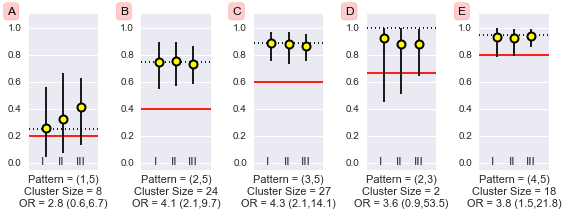

In [45]:
what_I = model_I_trace["theta_j"][:1000,:]
what_II = model_II_trace["theta_j"][:1000,:]
what_III = model_III_trace["theta_j"][:1000,:]
panelNames = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']

#### man, main
# fig, axes = plt.subplots(1, what_III.shape[1], figsize=(10,3))
#### women, main
# fig, axes = plt.subplots(3, 3, figsize=(5,10))
#### man, sens
fig, axes = plt.subplots(1, what_III.shape[1], figsize=(8,3))
#### women, sens
# fig, axes = plt.subplots(1, what_III.shape[1], figsize=(10,3))


axes = axes.ravel()
xlim = [-1, 3]
largerPSize = 10
smallerPSize = 6
for i in range(what_III.shape[1]):
    obsProb = finaldata['obsProb'][i]
    expProb = finaldata['expProb'][i]

    predicted_I = what_I[:,i]
    predicted_II = what_II[:,i]
    predicted_III = what_III[:,i]

    percY_I = np.percentile(predicted_I, q = [2.5, 97.5])
    percY_II = np.percentile(predicted_II, q = [2.5, 97.5])
    percY_III = np.percentile(predicted_III, q = [2.5, 97.5])

    pointY_I = np.mean(predicted_I)
    pointY_II = np.mean(predicted_II)
    pointY_III = np.mean(predicted_III)

    axes[i].hlines(expProb, xlim[0], xlim[1], linestyles='-', color = "red")
    axes[i].hlines(obsProb, xlim[0], xlim[1], linestyles='dotted', color = "black")
    # axes[i].text(-2., 1.1, panelNames[i], ha="center", color = 'k')
    
    axes[i].text(-2., 1.1, panelNames[i], ha="center", color = 'k', bbox=dict(boxstyle="round", ec=(1., 0.5, 0.5), fc=(1., 0.8, 0.8)))

    axes[i].vlines(0, percY_I[0], percY_I[1], linestyles='-')
    axes[i].vlines(1, percY_II[0], percY_II[1], linestyles='-')
    axes[i].vlines(2, percY_III[0], percY_III[1], linestyles='-')

    axes[i].plot(0, pointY_I, 'ro', markersize = largerPSize, color = "black")
    axes[i].plot(1, pointY_II, 'ro', markersize = largerPSize, color = "black")
    axes[i].plot(2, pointY_III, 'ro', markersize = largerPSize, color = "black")

    axes[i].plot(0, pointY_I, 'ro', markersize = smallerPSize, color = "yellow")
    axes[i].plot(1, pointY_II, 'ro', markersize = smallerPSize, color = "yellow")
    axes[i].plot(2, pointY_III, 'ro', markersize = smallerPSize, color = "yellow")
    
    shift = -.3
    axes[i].text(0 + shift, -.01, "I")
    axes[i].text(1 + shift, -.01, "II")
    axes[i].text(2 + shift, -.01, "III")

    axes[i].set_xlim(xlim)
    axes[i].set_ylim([-.05, 1.1])
    OR = ((pointY_III)/(1 - pointY_III)) / ((expProb)/(1 - expProb))
    OR_lower = ((percY_III[0])/(1 - percY_III[0])) / ((expectProbs[i])/(1 - expectProbs[i]))
    OR_upper = ((percY_III[1])/(1 - percY_III[1])) / ((expectProbs[i])/(1 - expectProbs[i]))
    axes[i].set_xlabel("Pattern = " + '(' + finaldata.index[i] + ')' + "\n" + "Cluster Size = " + str(finaldata[bNominVar][i]) + "\n" + "OR = "+ str(np.round(OR, 1)) + " ("+ str(np.round(OR_lower, 1)) + ","+ str(np.round(OR_upper, 1)) + ")")
    axes[i].set_xticks([])
plt.tight_layout()

In [46]:
fig.savefig('/Users/svetlanaeden/stuff/StatStuff/OSCAR_STUFF/' + plotFileName)

## Model comparison
Good website: https://docs.pymc.io/notebooks/model_comparison.html

In [47]:
pm3.waic(model_I_trace, model_I)

/Users/svetlanaeden/anaconda/envs/bios8366/lib/python3.5/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


WAIC_r(WAIC=18.130645007073653, WAIC_se=3.4483378264214086, p_WAIC=2.2806021004349115, var_warn=1)

In [48]:
pm3.waic(model_II_trace, model_II)

/Users/svetlanaeden/anaconda/envs/bios8366/lib/python3.5/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


WAIC_r(WAIC=18.84970179308497, WAIC_se=3.589860592682859, p_WAIC=2.479892359175481, var_warn=1)

In [49]:
pm3.waic(model_III_trace, model_III)

/Users/svetlanaeden/anaconda/envs/bios8366/lib/python3.5/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


WAIC_r(WAIC=15.788521462503098, WAIC_se=3.1790968727067797, p_WAIC=1.1788115981218787, var_warn=1)

In [110]:
pm3.waic(model_IV_trace, model_IV)

/Users/svetlanaeden/anaconda/envs/bios8366/lib/python3.5/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


WAIC_r(WAIC=15.93348736068084, WAIC_se=3.336866667580452, p_WAIC=1.2480667828164502, var_warn=1)

In [50]:
pm3.loo(model_I_trace, model_I)

/Users/svetlanaeden/anaconda/envs/bios8366/lib/python3.5/site-packages/pymc3/stats.py:292: UserWarning: Estimated shape parameter of Pareto distribution is
        greater than 0.7 for one or more samples.
        You should consider using a more robust model, this is because
        importance sampling is less likely to work well if the marginal
        posterior and LOO posterior are very different. This is more likely to
        happen with a non-robust model and highly influential observations.
  happen with a non-robust model and highly influential observations.""")


LOO_r(LOO=22.193413925926002, LOO_se=3.9039378638424886, p_LOO=4.311986559861088, shape_warn=1)

In [51]:
pm3.loo(model_II_trace, model_II)

/Users/svetlanaeden/anaconda/envs/bios8366/lib/python3.5/site-packages/pymc3/stats.py:292: UserWarning: Estimated shape parameter of Pareto distribution is
        greater than 0.7 for one or more samples.
        You should consider using a more robust model, this is because
        importance sampling is less likely to work well if the marginal
        posterior and LOO posterior are very different. This is more likely to
        happen with a non-robust model and highly influential observations.
  happen with a non-robust model and highly influential observations.""")


LOO_r(LOO=20.788848554837095, LOO_se=3.989431229646515, p_LOO=3.449465740051542, shape_warn=1)

In [52]:
pm3.loo(model_III_trace, model_III)

/Users/svetlanaeden/anaconda/envs/bios8366/lib/python3.5/site-packages/pymc3/stats.py:292: UserWarning: Estimated shape parameter of Pareto distribution is
        greater than 0.7 for one or more samples.
        You should consider using a more robust model, this is because
        importance sampling is less likely to work well if the marginal
        posterior and LOO posterior are very different. This is more likely to
        happen with a non-robust model and highly influential observations.
  happen with a non-robust model and highly influential observations.""")


LOO_r(LOO=16.32341805850728, LOO_se=3.2431330349510166, p_LOO=1.4462598961239683, shape_warn=1)

In [111]:
df_comp_WAIC = pm3.compare({model_I: model_I_trace, model_II: model_II_trace, model_III: model_III_trace, model_IV: model_IV_trace})
df_comp_WAIC

/Users/svetlanaeden/anaconda/envs/bios8366/lib/python3.5/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
2,15.79,1.18,0,1,3.18,0,1
3,15.93,1.25,0.14,0,3.34,0.26,1
0,18.13,2.28,2.34,0,3.45,1.03,1
1,18.85,2.48,3.06,0,3.59,0.55,1


Below, we compare AIC graphically for all three models

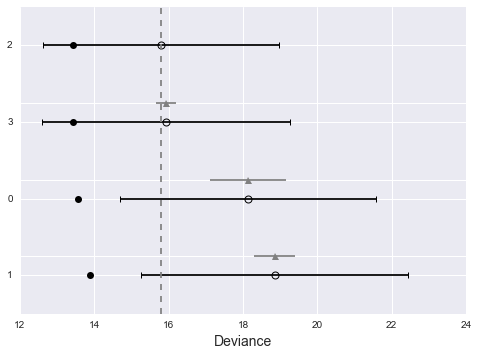

In [112]:
pm3.compareplot(df_comp_WAIC)

In [113]:
df_comp_LOO = pm3.compare({model_I: model_I_trace, model_II: model_II_trace, model_III: model_III_trace, model_IV: model_IV_trace}, ic = "LOO")
df_comp_LOO

/Users/svetlanaeden/anaconda/envs/bios8366/lib/python3.5/site-packages/pymc3/stats.py:292: UserWarning: Estimated shape parameter of Pareto distribution is
        greater than 0.7 for one or more samples.
        You should consider using a more robust model, this is because
        importance sampling is less likely to work well if the marginal
        posterior and LOO posterior are very different. This is more likely to
        happen with a non-robust model and highly influential observations.
  happen with a non-robust model and highly influential observations.""")


,LOO,pLOO,dLOO,weight,SE,dSE,shape_warn
2,16.32,1.45,0,1,3.24,0,1
3,16.62,1.59,0.3,0,3.53,0.52,1
1,20.79,3.45,4.47,0,3.99,1.01,1
0,22.19,4.31,5.87,0,3.9,0.8,1


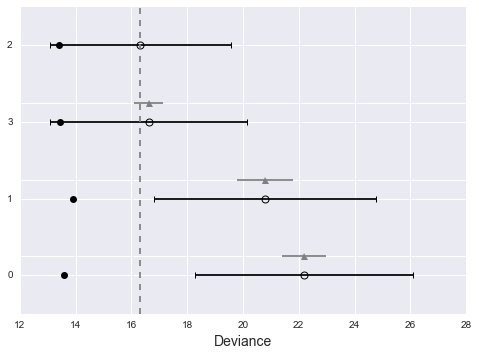

In [114]:
pm3.compareplot(df_comp_LOO)

## Checking the model goodness of fit using sampling from the posterior distribution

In [60]:
with model_I:
    model_I_sim = pm3.sample_ppc(model_I_trace, samples=500)
with model_II:
    model_II_sim = pm3.sample_ppc(model_II_trace, samples=500)
with model_III:
    model_III_sim = pm3.sample_ppc(model_III_trace, samples=500)

100%|██████████| 500/500 [00:00<00:00, 1471.22it/s]


In [61]:
# checking out the items in the object
for key, value in model_I_sim.items() :
    print (key)

y_like


In [62]:
model_II_sim['y_like'].shape

(500, 5)

In [63]:
model_II_sim['y_like'][0:4, 0:6]

array([[ 2, 20, 25,  2, 14],
       [ 1, 15, 19,  2, 13],
       [ 1, 19, 19,  2, 18],
       [ 2, 18, 22,  2, 18]])

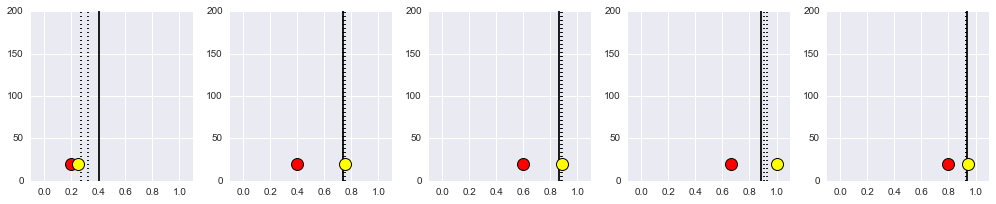

In [64]:
numOfParam = model_II_sim['y_like'].shape[1]
fig, axes = plt.subplots(1, numOfParam, figsize=(14,3))
axes = axes.ravel()
for i in range(numOfParam):
    tmp1 = model_I_sim['y_like'][:,i]/N_j[i]
    tmp2 = model_II_sim['y_like'][:,i]/N_j[i]
    tmp3 = model_III_sim['y_like'][:,i]/N_j[i]
    median1 = np.round(np.percentile(model_I_sim['y_like'][:,i], q = [50]), 2)/N_j[i]
    median2 = np.round(np.percentile(model_II_sim['y_like'][:,i], q = [50]), 2)/N_j[i] 
    median3 = np.round(np.percentile(model_III_sim['y_like'][:,i], q = [50]), 2)/N_j[i] 
    
    mean1 = np.mean(model_I_sim['y_like'][:,i])/N_j[i]
    mean2 = np.mean(model_II_sim['y_like'][:,i])/N_j[i]
    mean3 = np.mean(model_III_sim['y_like'][:,i])/N_j[i]


#     axes[i].hist(tmp3, bins = 25)
    pointY = 20
    pointSize = 13
    axes[i].plot(expectProbs[i], pointY, 'go', markersize = pointSize, color = "black")
    axes[i].plot(expectProbs[i], pointY, 'go', markersize = pointSize-2, color = "red")
    axes[i].plot(observProbs[i], pointY, 'ro', markersize = pointSize, color = "black")
    axes[i].plot(observProbs[i], pointY, 'ro', markersize = pointSize-2, color = "yellow")

#     axes[i].vlines(median1[0], 0, 300)
#     axes[i].vlines(median2[0], 0, 300)
#     axes[i].vlines(median3[0], 0, 300, color = "green")

    axes[i].vlines(mean1, 0, 300, linestyles = "dotted")
    axes[i].vlines(mean2, 0, 300, linestyles = "dotted")
    axes[i].vlines(mean3, 0, 300)

    axes[i].set_xlim([-.1, 1.1])
    axes[i].set_ylim([0, 200])
plt.tight_layout()

In [65]:
median3[0]

0.9444444444444444

## Model diagnostic

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11a9545c0>,
      dtype=object)

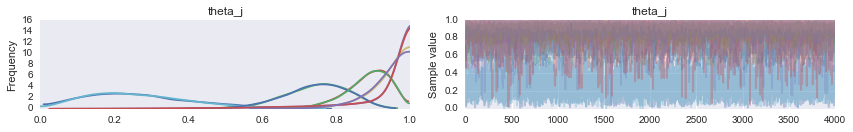

In [66]:
pm3.traceplot(model_I_trace, varnames=['theta_j'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11a8a7cf8>,
      dtype=object)

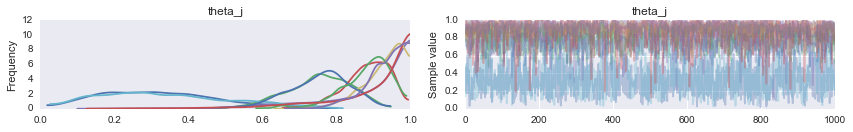

In [67]:
pm3.traceplot(model_II_trace, varnames=['theta_j'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11e49ef98>,
      dtype=object)

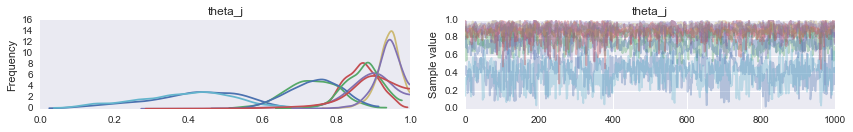

In [68]:
pm3.traceplot(model_III_trace, varnames=['theta_j'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11ff1fa58>,
      dtype=object)

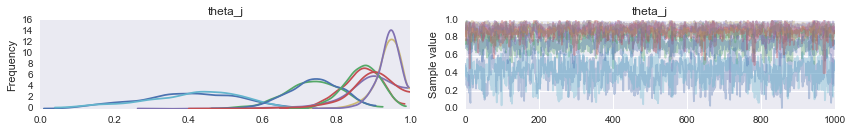

In [136]:
pm3.traceplot(model_IV_trace, varnames=['theta_j'])

array([-0.86319786,  0.37285046,  1.59716726])

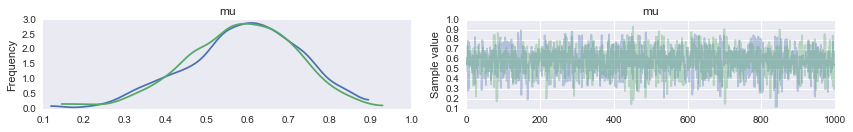

In [165]:
pm3.traceplot(model_I_trace, varnames=['mu'])
np.percentile(-np.log(1/model_I_trace["mu"]-1), q = [2.5, 50, 97.5])
# model_I_trace["mu"]

array([0.55972345, 0.69880897, 0.73083927])

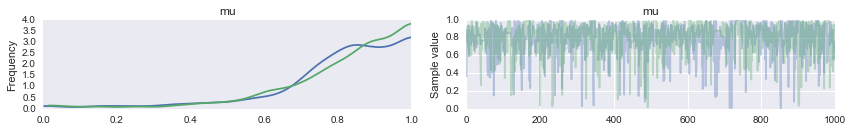

In [164]:
pm3.traceplot(model_II_trace, varnames=['mu'])
np.percentile((1/(1 + np.exp(-model_II_trace["mu"]))), q = [2.5, 50, 97.5])

array([0.29056263, 1.40420964, 2.66161455])

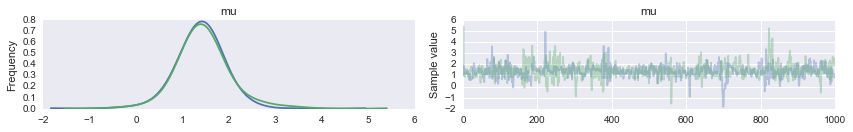

In [162]:
pm3.traceplot(model_III_trace, varnames=['mu'])
np.percentile((1/(1 + np.exp(-model_III_trace["mu"]))), q = [2.5, 50, 97.5])
np.percentile(model_III_trace["mu"], q = [2.5, 50, 97.5])

array([0.38090451, 1.39803948, 2.81649142])

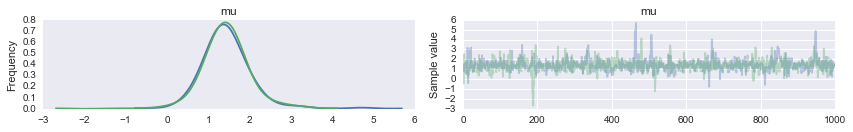

In [163]:
pm3.traceplot(model_IV_trace, varnames=['mu'])
np.percentile((1/(1 + np.exp(-model_IV_trace["mu"]))), q = [2.5, 50, 97.5])
np.percentile(model_IV_trace["mu"], q = [2.5, 50, 97.5])

Here we check if the histograms are about the same no matter what window we pick (please change it to work for your data)

In [71]:

# beta_trace = bioassay_trace['beta']

# fig, axes = plt.subplots(2, 5, figsize=(14,6))
# axes = axes.ravel()
# for i in range(10):
#     axes[i].hist(beta_trace[500*i:500*(i+1)])
# plt.tight_layout()

In [95]:
pm3.forestplot(model_III_trace, varnames=['theta_j'])

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x10cace730> (for post_execute):


ValueError: to_rgba: Invalid rgba arg "C0"
to_rgb: Invalid rgb arg "C0"
could not convert string to float: 'c0'

ValueError: to_rgba: Invalid rgba arg "C0"
to_rgb: Invalid rgb arg "C0"
could not convert string to float: 'c0'

In [74]:
with model_I:
    tr = pm3.sample(2000)
    
z = pm3.geweke(tr, intervals=15)

Sampling 2 chains: 100%|██████████| 5000/5000 [00:05<00:00, 860.49draws/s]


KeyError: 'mu'

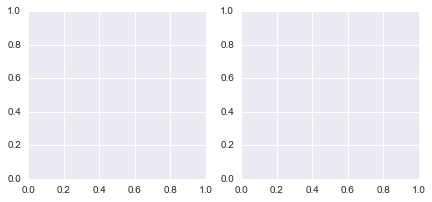

In [75]:
# fig, axes = plt.subplots(2, 4, figsize=(14,6))
# axes = axes.ravel()
#     axes[i].scatter(*z['theta_j'][1].T)
#     plt.hlines([-1,1], 0, 1000, linestyles='dotted')
#     plt.xlim(0, 1000)

fig, axes = plt.subplots(1, 2, figsize=(7,3))
axes = axes.ravel()
axes[0].scatter(*z['mu'].T)
axes[0].hlines([-1,1], 0, 1000, linestyles='dotted')
plt.xlim(0, 1000)
plt.scatter(*z['tau'].T)
plt.hlines([-1,1], 0, 1000, linestyles='dotted')
plt.xlim(0, 1000)
plt.tight_layout()

KeyError: 'theta_j'

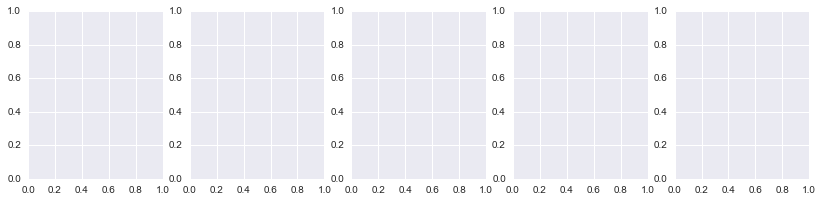

In [76]:
fig, axes = plt.subplots(1, theta_trace.shape[1], figsize=(14,3))
axes = axes.ravel()
for i in range(theta_trace.shape[1]):
    axes[i].scatter(*z['theta_j'][i].T)
    axes[i].hlines([-1,1], 0, 1000, linestyles='dotted')
    plt.xlim(0, 1000)
plt.tight_layout()

In [77]:
pm3.gelman_rubin(model_for_actors_trace)

NameError: name 'model_for_actors_trace' is not defined

## Checking autocorrelation in the sampled parameters
Q to Dave: how to check autocorrelation plot for each parameters? I am asking because from the output I cannot tell which parameter is where...

In [78]:
pm3.autocorrplot(model_for_actors_trace)

NameError: name 'model_for_actors_trace' is not defined

## Checking the model goodness of fit using sampling from the posterior distribution


In [79]:
with model_for_actors:
    wins_sim = pm3.sample_ppc(model_for_actors_trace, samples=500)
    
# wins_sim.item()
for key, value in wins_sim.items() :
    print (key)
    

wins_sim['y_like'].shape
fig, axes = plt.subplots(1, theta_trace.shape[1], figsize=(14,3))
axes = axes.ravel()
for i in range(theta_trace.shape[1]):
    tmp = wins_sim['y_like'][:,i]/N_j[i]
    axes[i].hist(tmp, bins = 25)
    pointY = 20
    pointSize = 13
    axes[i].plot(expectProbs[i], pointY, 'go', markersize = pointSize, color = "black")
    axes[i].plot(expectProbs[i], pointY, 'go', markersize = pointSize-2, color = "red")
    axes[i].plot(observProbs[i], pointY, 'ro', markersize = pointSize, color = "black")
    axes[i].plot(observProbs[i], pointY, 'ro', markersize = pointSize-2, color = "yellow")
    axes[i].set_xlim([-.1, 1.1])
    axes[i].set_ylim([0, 200])
plt.tight_layout()

NameError: name 'model_for_actors' is not defined

# Old model

In [434]:
### Binomial model with Beta prior
with pm3.Model() as model_IIab:
    
    # Logit-linear model parameters
    alpha1 = pm3.Gamma('alpha1', alpha = 1, beta = 10)
    beta1 = pm3.Gamma('beta1', alpha = 1, beta = 10)
    theta_j = pm3.Beta('theta_j', alpha = alpha1, beta = beta1, shape = expectProbs.shape[0])

    # Data likelihood
    y_like = pm3.Binomial('y_like', p = theta_j, n = N_j, observed = R_j)

Applied log-transform to alpha1 and added transformed alpha1_log_ to model.
Applied log-transform to beta1 and added transformed beta1_log_ to model.
Applied logodds-transform to theta_j and added transformed theta_j_logodds_ to model.


In [435]:
# with model_for_actors:
#     model_for_actors_trace = pm3.sample(1000, njobs=2, random_seed=RANDOM_SEEDS)


with model_IIab:
    model_IIab_trace = pm3.sample(1000, njobs=2, random_seed=RANDOM_SEEDS)

Assigned NUTS to alpha1_log_
Assigned NUTS to beta1_log_
Assigned NUTS to theta_j_logodds_
 [-----------------100%-----------------] 1000 of 1000 complete in 4.6 sec

In [436]:

model_IIab_sample = model_IIab_trace[1]

### find out what is in the trace:
for key, value in model_IIab_sample.items() :
    print (key)

theta_j_logodds_
beta1
beta1_log_
alpha1
alpha1_log_
theta_j


## Results of the old model

In [437]:
model_IIab_sample["beta1"]

0.13693983142311145

In [438]:

sample_trace_theta = model_for_actors_trace["theta_j"]

### find out dimention of thetas
sample_trace_theta.shape





sample_trace_theta_IIab = model_IIab_trace["theta_j"]
whatToPlot = sample_trace_theta_IIab[500:1000,]
range(whatToPlot.shape[1])

range(0, 5)

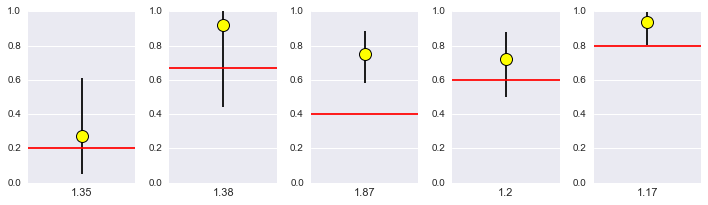

In [442]:
fig, axes = plt.subplots(1, whatToPlot.shape[1], figsize=(10,3))
axes = axes.ravel()
xlim = [-.5, .5]
for i in range(whatToPlot.shape[1]):
    tmp = wins_sim['y_like'][:,i]/N_j[i]
    predicted = whatToPlot[:,i]
    percY = np.percentile(predicted, q = [2.5, 97.5])

    pointY = np.mean(predicted)
    axes[i].vlines(0, percY[0], percY[1], linestyles='-')
    axes[i].hlines(expectProbs[i], xlim[0], xlim[1], linestyles='-', color = "red")
    axes[i].plot(0, pointY, 'ro', markersize = 13, color = "black")
    axes[i].plot(0, pointY, 'ro', markersize = 11, color = "yellow")
    axes[i].set_xlim(xlim)
    axes[i].set_ylim([0, 1])
    OR = ((pointY)/(1 - pointY)) / ((expectProbs[i])/(1 - expectProbs[i]))
    RR = pointY / expectProbs[i]
    axes[i].set_xlabel(np.round(RR, 2))
    axes[i].set_xticks([])
plt.tight_layout()

## Model diagnostic for the old model

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1237fe5c0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x13af4dc50>]], dtype=object)

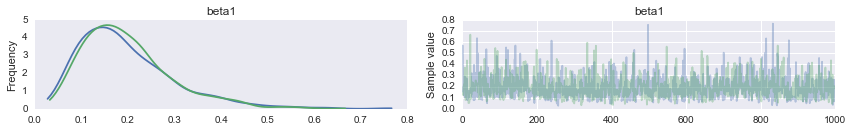

In [443]:
### q to Dave: why my beta's are so different?
### when I run:
# pm3.traceplot(model_IIab_trace[-10:], varnames=['beta1'])
pm3.traceplot(model_IIab_trace, varnames=['beta1'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x147111c50>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1360fd588>]], dtype=object)

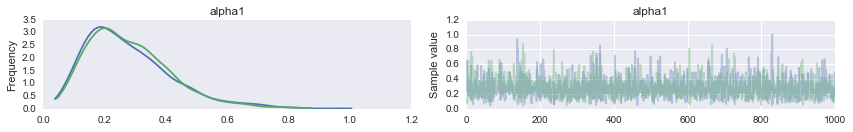

In [444]:
pm3.traceplot(model_IIab_trace, varnames=['alpha1'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1360d9c50>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x14246b400>]], dtype=object)

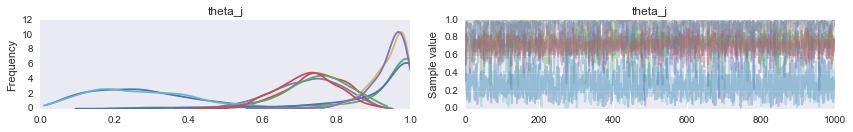

In [445]:
### q to Dave: how to plot each parameter theta_j
pm3.traceplot(model_IIab_trace, varnames=['theta_j'])

In [446]:
theta_trace = model_IIab_trace["theta_j"]
theta_trace.shape


(2000, 5)

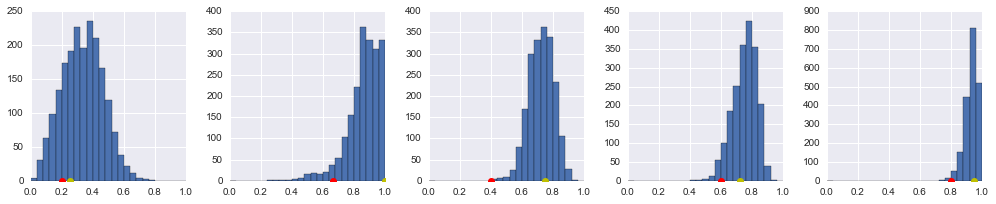

In [486]:
### q to Dave: how to overlay the observed probabilities with these plots

fig, axes = plt.subplots(1, theta_trace.shape[1], figsize=(14,3))
axes = axes.ravel()
for i in range(theta_trace.shape[1]):
    tmp = theta_trace[:,i]
    axes[i].hist(tmp, range = (0, 1), bins = 25)
    axes[i].plot(expectProbs[i], 0, 'ro')
    axes[i].plot(observProbs[i], 0, 'yo')
plt.tight_layout()

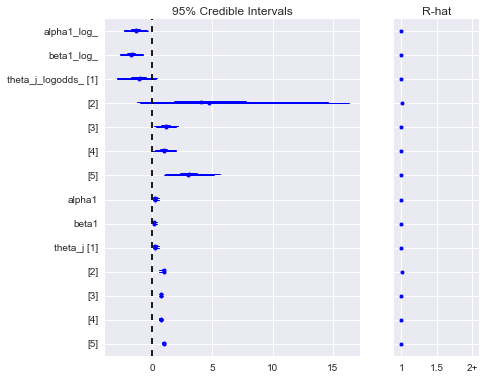

In [448]:
pm3.forestplot(model_IIab_trace)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x158a48c18>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x15e0ae240>]], dtype=object)

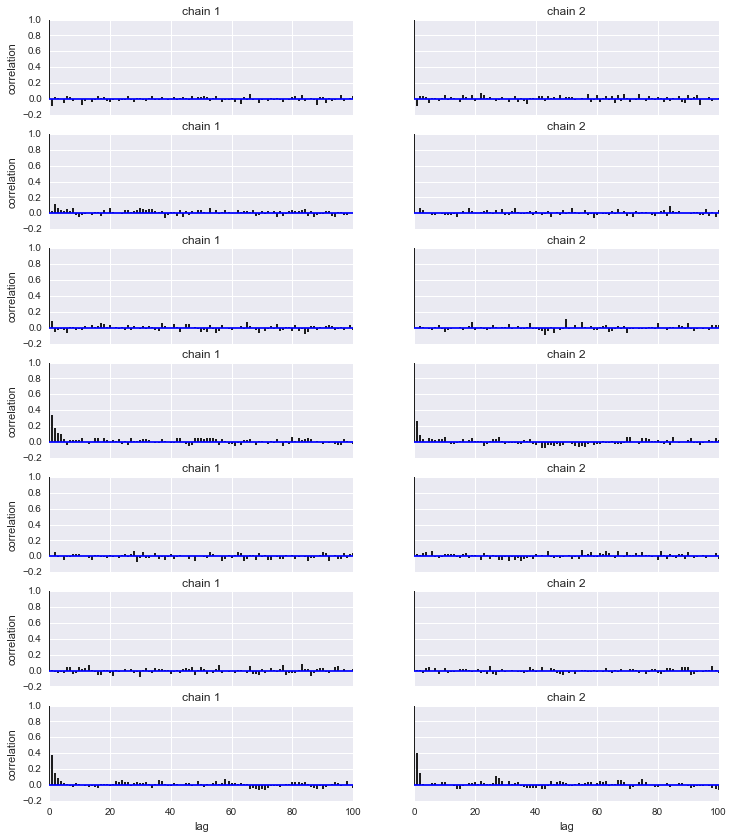

In [449]:
pm3.autocorrplot(model_IIab_trace)

In [ ]:
### Check if winning BP is affected by BA

In [519]:
RANDOM_SEEDS = [5142018, 3211968]
n_j = np.array([5, 10, 12, 5, 8, 10, 5, 9, 10, 5, 8, 10, 9])
r_j = np.array([1, 2,   2, 2, 2,  3, 3, 3,  4, 4, 4,  5, 5])
N_j = np.array([8, 2,   2,26, 1,  3,23, 2,  4, 6, 1,  2, 1])
R_j = np.array([4, 1,   2,15, 0,  1,17, 1,  3, 6, 1,  2, 1])

# n_j = np.array([5, 3, 4, 5, 4, 5, 5])
# r_j = np.array([1, 2, 2, 2, 3, 3, 4])
# N_j = np.array([8, 3, 5, 23, 5, 23, 10])
# R_j = np.array([2, 3, 4, 17, 4, 21, 10])

observProbs = np.divide(R_j, N_j)
expectProbs = np.divide(r_j, n_j)
expectProbs

array([ 0.2       ,  0.2       ,  0.16666667,  0.4       ,  0.25      ,
        0.3       ,  0.6       ,  0.33333333,  0.4       ,  0.8       ,
        0.5       ,  0.5       ,  0.55555556])

# Model diagnostics

I am using this files because I wanted to have also the diagnostics after I run all mu models.

After running an MCMC simulation, `sample` returns a `MutliTrace` object containing the samples for all the stochastic and deterministic random variables. The final step in Bayesian computation is model checking, in order to ensure that inferences derived from your sample are valid. There are two components to model checking:

1. Convergence diagnostics
2. Goodness of fit

Convergence diagnostics are intended to detect lack of convergence in the Markov chain Monte Carlo sample; it is used to ensure that you have not halted your sampling too early. However, a converged model is not guaranteed to be a good model. The second component of model checking, goodness of fit, is used to check the internal validity of the model, by comparing predictions from the model to the data used to fit the model. 

## Convergence Diagnostics

Valid inferences from sequences of MCMC samples are based on the
assumption that the samples are derived from the true posterior
distribution of interest. Theory guarantees this condition as the number
of iterations approaches infinity. It is important, therefore, to
determine the **minimum number of samples** required to ensure a reasonable
approximation to the target posterior density. Unfortunately, no
universal threshold exists across all problems, so convergence must be
assessed independently each time MCMC estimation is performed. The
procedures for verifying convergence are collectively known as
*convergence diagnostics*.

One approach to analyzing convergence is **analytical**, whereby the
variance of the sample at different sections of the chain are compared
to that of the limiting distribution. These methods use distance metrics
to analyze convergence, or place theoretical bounds on the sample
variance, and though they are promising, they are generally difficult to
use and are not prominent in the MCMC literature. More common is a
**statistical** approach to assessing convergence. With this approach,
rather than considering the properties of the theoretical target
distribution, only the statistical properties of the observed chain are
analyzed. Reliance on the sample alone restricts such convergence
criteria to **heuristics**. As a result, convergence cannot be guaranteed.
Although evidence for lack of convergence using statistical convergence
diagnostics will correctly imply lack of convergence in the chain, the
absence of such evidence will not *guarantee* convergence in the chain.
Nevertheless, negative results for one or more criteria may provide some
measure of assurance to users that their sample will provide valid
inferences.

For most simple models, convergence will occur quickly, sometimes within
a the first several hundred iterations, after which all remaining
samples of the chain may be used to calculate posterior quantities. For
more complex models, convergence requires a significantly longer burn-in
period; sometimes orders of magnitude more samples are needed.
Frequently, lack of convergence will be caused by **poor mixing**. 
Recall that *mixing* refers to the degree to which the Markov
chain explores the support of the posterior distribution. Poor mixing
may stem from inappropriate proposals (if one is using the
Metropolis-Hastings sampler) or from attempting to estimate models with
highly correlated variables.

In [2]:
# # Samples for each dose level
# n = 5 * np.ones(4, dtype=int)
# # Log-dose
# dose = np.array([-.86, -.3, -.05, .73])
# deaths = np.array([0, 1, 3, 5])

# with Model() as bioassay_model:

#     # Logit-linear model parameters
#     alpha = Normal('alpha', 0, sd=100)
#     beta = Normal('beta', 0, sd=100)

#     # Calculate probabilities of death
#     theta = invlogit(alpha + beta * dose)

#     # Data likelihood
#     obs_deaths = Binomial('obs_deaths', n=n, p=theta, observed=deaths)

In [3]:
# with bioassay_model:
#     bioassay_trace = sample(1000)

Assigned NUTS to alpha
Assigned NUTS to beta
 [-----------------100%-----------------] 1000 of 1000 complete in 0.5 sec

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x113ae7c50>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x113d35f28>]], dtype=object)

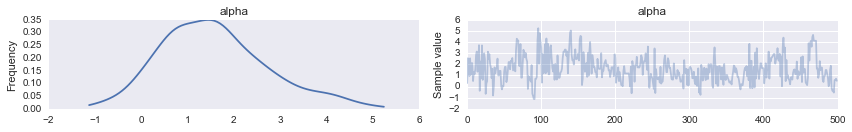

In [4]:
# from pymc3 import traceplot

# traceplot(bioassay_trace[500:], varnames=['alpha'])

### Informal Methods

The most straightforward approach for assessing convergence is based on
simply **plotting and inspecting traces and histograms** of the observed
MCMC sample. If the trace of values for each of the stochastics exhibits
asymptotic behavior over the last $m$ iterations, this may be
satisfactory evidence for convergence. 

Assigned NUTS to alpha
Assigned NUTS to beta
 [-----------------100%-----------------] 10000 of 10000 complete in 4.9 sec

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1134887b8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1134994a8>]], dtype=object)

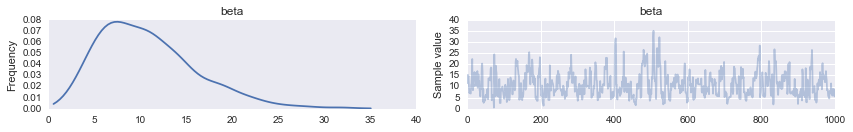

In [5]:
with bioassay_model:
    bioassay_trace = sample(10000)
    
traceplot(bioassay_trace[-1000:], varnames=['beta'])

A similar approach involves
plotting a histogram for every set of $k$ iterations (perhaps 50-100)
beyond some burn in threshold $n$; if the histograms are not visibly
different among the sample intervals, this may be considered some evidence for
convergence. Note that such diagnostics should be carried out for each
stochastic estimated by the MCMC algorithm, because convergent behavior
by one variable does not imply evidence for convergence for other
variables in the analysis. 

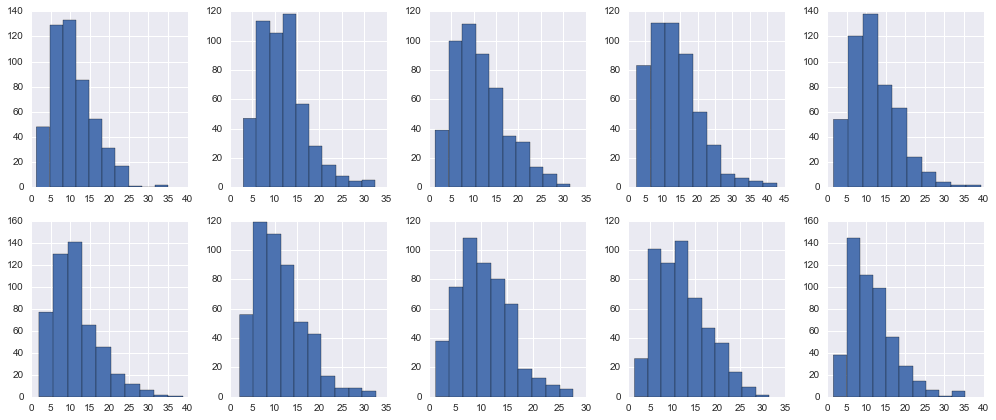

In [6]:
import matplotlib.pyplot as plt

beta_trace = bioassay_trace['beta']

fig, axes = plt.subplots(2, 5, figsize=(14,6))
axes = axes.ravel()
for i in range(10):
    axes[i].hist(beta_trace[500*i:500*(i+1)])
plt.tight_layout()

An extension of this approach can be taken
when multiple parallel chains are run, rather than just a single, long
chain. In this case, the final values of $c$ chains run for $n$
iterations are plotted in a histogram; just as above, this is repeated
every $k$ iterations thereafter, and the histograms of the endpoints are
plotted again and compared to the previous histogram. This is repeated
until consecutive histograms are indistinguishable.

Another *ad hoc* method for detecting lack of convergence is to examine
the traces of several MCMC chains initialized with different starting
values. Overlaying these traces on the same set of axes should (if
convergence has occurred) show each chain tending toward the same
equilibrium value, with approximately the same variance. Recall that the
tendency for some Markov chains to converge to the true (unknown) value
from diverse initial values is called *ergodicity*. This property is
guaranteed by the reversible chains constructed using MCMC, and should
be observable using this technique. Again, however, this approach is
only a heuristic method, and cannot always detect lack of convergence,
even though chains may appear ergodic.

In [7]:
with bioassay_model:
    
    bioassay_trace = sample(1000, njobs=2, start=[{'alpha':0.5}, {'alpha':5}])

Assigned NUTS to alpha
Assigned NUTS to beta
 [-----------------100%-----------------] 1000 of 1000 complete in 1.3 sec

In [8]:
bioassay_trace.get_values('alpha', chains=0)[0]

-0.91779909154880746

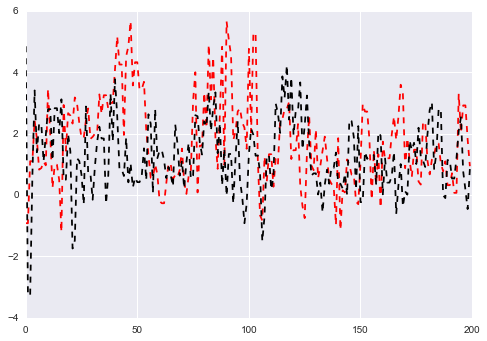

In [9]:
plt.plot(bioassay_trace.get_values('alpha', chains=0)[:200], 'r--')
plt.plot(bioassay_trace.get_values('alpha', chains=1)[:200], 'k--')

A principal reason that evidence from informal techniques cannot
guarantee convergence is a phenomenon called ***metastability***. Chains may
appear to have converged to the true equilibrium value, displaying
excellent qualities by any of the methods described above. However,
after some period of stability around this value, the chain may suddenly
move to another region of the parameter space. This period
of metastability can sometimes be very long, and therefore escape
detection by these convergence diagnostics. Unfortunately, there is no
statistical technique available for detecting metastability.

### Formal Methods

Along with the *ad hoc* techniques described above, a number of more
formal methods exist which are prevalent in the literature. These are
considered more formal because they are based on existing statistical
methods, such as time series analysis.

PyMC currently includes three formal convergence diagnostic methods. The
first, proposed by [Geweke (1992)](http://projecteuclid.org/DPubS?service=UI&version=1.0&verb=Display&handle=euclid.ss/1177011446), is a time-series approach that
compares the mean and variance of segments from the beginning and end of
a single chain.

$$z = \frac{\bar{\theta}_a - \bar{\theta}_b}{\sqrt{S_a(0) + S_b(0)}}$$

where $a$ is the early interval and $b$ the late interval, and $S_i(0)$ is the spectral density estimate at zero frequency for chain segment $i$. If the
z-scores (theoretically distributed as standard normal variates) of
these two segments are similar, it can provide evidence for convergence.
PyMC calculates z-scores of the difference between various initial
segments along the chain, and the last 50% of the remaining chain. If
the chain has converged, the majority of points should fall within 2
standard deviations of zero.

In PyMC, diagnostic z-scores can be obtained by calling the `geweke` function. It
accepts either (1) a single trace, (2) a Node or Stochastic object, or
(4) an entire Model object:

In [10]:
from pymc3 import geweke

with bioassay_model:
    tr = sample(2000)
    
z = geweke(tr, intervals=15)

Assigned NUTS to alpha
Assigned NUTS to beta
 [-----------------100%-----------------] 2000 of 2000 complete in 1.0 sec

(0, 1000)

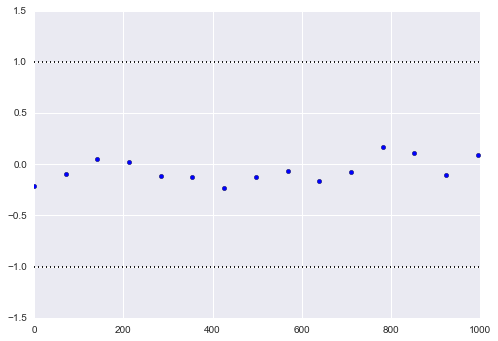

In [11]:
plt.scatter(*z['alpha'].T)
plt.hlines([-1,1], 0, 1000, linestyles='dotted')
plt.xlim(0, 1000)

The arguments expected are the following:

- `x` : The trace of a variable.
- `first` : The fraction of series at the beginning of the trace.
- `last` : The fraction of series at the end to be compared with the section at the beginning.
- `intervals` : The number of segments.

Plotting the output displays the scores in series, making it is easy to
see departures from the standard normal assumption.

A second convergence diagnostic provided by PyMC is the Gelman-Rubin
statistic [Gelman and Rubin (1992)](http://projecteuclid.org/DPubS?service=UI&version=1.0&verb=Display&handle=euclid.ss/1177011136). This diagnostic uses multiple chains to
check for lack of convergence, and is based on the notion that if
multiple chains have converged, by definition they should appear very
similar to one another; if not, one or more of the chains has failed to
converge.

The Gelman-Rubin diagnostic uses an analysis of variance approach to
assessing convergence. That is, it calculates both the between-chain
varaince (B) and within-chain varaince (W), and assesses whether they
are different enough to worry about convergence. Assuming $m$ chains,
each of length $n$, quantities are calculated by:

$$\begin{align}B &= \frac{n}{m-1} \sum_{j=1}^m (\bar{\theta}_{.j} - \bar{\theta}_{..})^2 \\
W &= \frac{1}{m} \sum_{j=1}^m \left[ \frac{1}{n-1} \sum_{i=1}^n (\theta_{ij} - \bar{\theta}_{.j})^2 \right]
\end{align}$$

for each scalar estimand $\theta$. Using these values, an estimate of
the marginal posterior variance of $\theta$ can be calculated:

$$\hat{\text{Var}}(\theta | y) = \frac{n-1}{n} W + \frac{1}{n} B$$

Assuming $\theta$ was initialized to arbitrary starting points in each
chain, this quantity will overestimate the true marginal posterior
variance. At the same time, $W$ will tend to underestimate the
within-chain variance early in the sampling run. However, in the limit
as $n \rightarrow 
\infty$, both quantities will converge to the true variance of $\theta$.
In light of this, the Gelman-Rubin statistic monitors convergence using
the ratio:

$$\hat{R} = \sqrt{\frac{\hat{\text{Var}}(\theta | y)}{W}}$$

This is called the potential scale reduction, since it is an estimate of
the potential reduction in the scale of $\theta$ as the number of
simulations tends to infinity. In practice, we look for values of
$\hat{R}$ close to one (say, less than 1.1) to be confident that a
particular estimand has converged. In PyMC, the function
`gelman_rubin` will calculate $\hat{R}$ for each stochastic node in
the passed model:

In [12]:
from pymc3 import gelman_rubin

gelman_rubin(bioassay_trace)

{'alpha': 1.0004514431477829, 'beta': 1.0015509479608087}

For the best results, each chain should be initialized to highly
dispersed starting values for each stochastic node.

By default, when calling the `forestplot` function using nodes with
multiple chains, the $\hat{R}$ values will be plotted alongside the
posterior intervals.

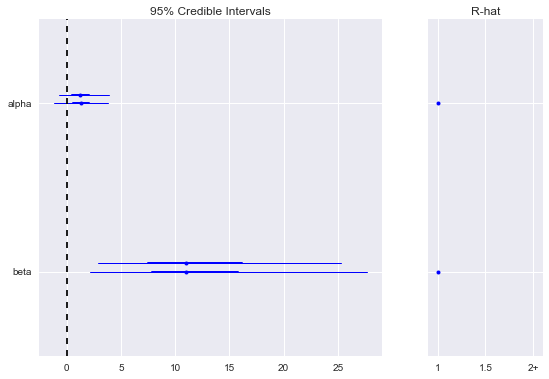

In [13]:
from pymc3 import forestplot

forestplot(bioassay_trace)

## Autocorrelation

In general, samples drawn from MCMC algorithms will be autocorrelated. This is not a big deal, other than the fact that autocorrelated chains may require longer sampling in order to adequately characterize posterior quantities of interest. The calculation of autocorrelation is performed for each lag $i=1,2,\ldots,k$ (the correlation at lag 0 is, of course, 1) by: 

$$\hat{\rho}_i = 1 - \frac{V_i}{2\hat{\text{Var}}(\theta | y)}$$

where $\hat{\text{Var}}(\theta | y)$ is the same estimated variance as calculated for the Gelman-Rubin statistic, and $V_i$ is the variogram at lag $i$ for $\theta$:

$$\text{V}_i = \frac{1}{m(n-i)}\sum_{j=1}^m \sum_{k=i+1}^n (\theta_{jk} - \theta_{j(k-i)})^2$$

This autocorrelation can be visualized using the `autocorrplot` function in PyMC3:

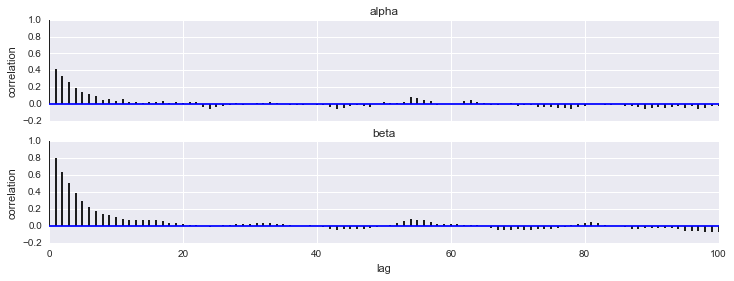

In [14]:
from pymc3 import autocorrplot

autocorrplot(tr);

The effective sample size is estimated using the partial sum:

$$\hat{n}_{eff} = \frac{mn}{1 + 2\sum_{i=1}^T \hat{\rho}_i}$$

where $T$ is the first odd integer such that $\hat{\rho}_{T+1} + \hat{\rho}_{T+2}$ is negative.

In [15]:
from pymc3 import effective_n

effective_n(bioassay_trace)

{'alpha': 361, 'beta': 173}

It is tempting to want to **thin** the chain to eliminate the autocorrelation (\emph{e.g} taking every 20th sample from the traces above), but this is a waste of time. Since thinning deliberately throws out the majority of the samples, no efficiency is gained; you ultimately require more samples to achive a particular desired sample size. 

## Goodness of Fit

Checking for model convergence is only the first step in the evaluation
of MCMC model outputs. It is possible for an entirely unsuitable model
to converge, so additional steps are needed to ensure that the estimated
model adequately fits the data. One intuitive way of evaluating model
fit is to compare model predictions with the observations used to fit
the model. In other words, the fitted model can be used to simulate
data, and the distribution of the simulated data should resemble the
distribution of the actual data.

Fortunately, simulating data from the model is a natural component of
the Bayesian modelling framework. Recall, from the discussion on
imputation of missing data, the posterior predictive distribution:

$$p(\tilde{y}|y) = \int p(\tilde{y}|\theta) f(\theta|y) d\theta$$

Here, $\tilde{y}$ represents some hypothetical new data that would be
expected, taking into account the posterior uncertainty in the model
parameters. 

Sampling from the posterior predictive distribution is easy
in PyMC. The `sample_ppc` function draws posterior predictive checks from all of the data likelhioods. Consider the `gelman_bioassay` example, 
where deaths are modeled as a binomial random variable for which
the probability of death is a logit-linear function of the dose of a
particular drug.

The posterior predictive distribution of deaths uses the same functional
form as the data likelihood, in this case a binomial stochastic. Here is
the corresponding sample from the posterior predictive distribution (we typically need very few samples relative to the MCMC sample):

In [16]:
from pymc3 import sample_ppc

with bioassay_model:
    deaths_sim = sample_ppc(bioassay_trace, samples=500)

The degree to which simulated data correspond to observations can be evaluated in at least two ways. First, these quantities can simply be compared visually. This allows for a qualitative comparison of model-based replicates and observations. If there is poor fit, the true value of the data may appear in the tails of the histogram of replicated data, while a good fit will tend to show the true data in high-probability regions of the posterior predictive distribution. The Matplot package in PyMC provides an easy way of producing such plots, via the `gof_plot` function.

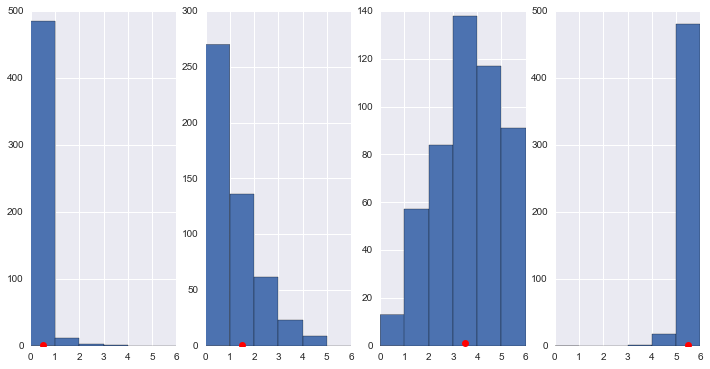

In [17]:
fig, axes = plt.subplots(1, 4, figsize=(12, 6))

for obs, sim, ax in zip(deaths, deaths_sim['obs_deaths'].T, axes):
    ax.hist(sim, bins=range(7))
    ax.plot(obs+0.5, 1, 'ro')

## Exercise: Meta-analysis of beta blocker effectiveness

Carlin (1992) considers a Bayesian approach to meta-analysis, and includes the following examples of 22 trials of beta-blockers to prevent mortality after myocardial infarction.

In a random effects meta-analysis we assume the true effect (on a log-odds scale) $d_i$ in a trial $i$
is drawn from some population distribution. Let $r^C_i$ denote number of events in the control group in trial $i$,
and $r^T_i$ denote events under active treatment in trial $i$. Our model is:

$$\begin{aligned}
r^C_i &\sim \text{Binomial}\left(p^C_i, n^C_i\right) \\
r^T_i &\sim \text{Binomial}\left(p^T_i, n^T_i\right) \\
\text{logit}\left(p^C_i\right) &= \mu_i \\
\text{logit}\left(p^T_i\right) &= \mu_i + \delta_i \\
\delta_i &\sim \text{Normal}(d, t) \\
\mu_i &\sim \text{Normal}(m, s)
\end{aligned}$$

We want to make inferences about the population effect $d$, and the predictive distribution for the effect $\delta_{\text{new}}$ in a new trial. Build a model to estimate these quantities in PyMC, and (1) use convergence diagnostics to check for convergence and (2) use posterior predictive checks to assess goodness-of-fit.

Here are the data:

In [ ]:
r_t_obs = [3, 7, 5, 102, 28, 4, 98, 60, 25, 138, 64, 45, 9, 57, 25, 33, 28, 8, 6, 32, 27, 22]
n_t_obs = [38, 114, 69, 1533, 355, 59, 945, 632, 278,1916, 873, 263, 291, 858, 154, 207, 251, 151, 174, 209, 391, 680]
r_c_obs = [3, 14, 11, 127, 27, 6, 152, 48, 37, 188, 52, 47, 16, 45, 31, 38, 12, 6, 3, 40, 43, 39]
n_c_obs = [39, 116, 93, 1520, 365, 52, 939, 471, 282, 1921, 583, 266, 293, 883, 147, 213, 122, 154, 134, 218, 364, 674]
N = len(n_c_obs)

In [ ]:
# Write your answer here

## References

Gelman, A., & Rubin, D. B. (1992). Inference from iterative simulation using multiple sequences. Statistical Science. A Review Journal of the Institute of Mathematical Statistics, 457–472.

Geweke, J., Berger, J. O., & Dawid, A. P. (1992). Evaluating the accuracy of sampling-based approaches to the calculation of posterior moments. In Bayesian Statistics 4.

Brooks, S. P., Catchpole, E. A., & Morgan, B. J. T. (2000). Bayesian Animal Survival Estimation. Statistical Science. A Review Journal of the Institute of Mathematical Statistics, 15(4), 357–376. doi:10.1214/ss/1177010123

Gelman, A., Meng, X., & Stern, H. (1996). Posterior predicitive assessment of model fitness via realized discrepencies with discussion. Statistica Sinica, 6, 733–807.

Raftery, A., & Lewis, S. (1992). One long run with diagnostics: Implementation strategies for Markov chain Monte Carlo. Statistical Science. A Review Journal of the Institute of Mathematical Statistics, 7, 493–497.

[CrossValidated: How to use scikit-learn's cross validation functions on multi-label classifiers](http://stats.stackexchange.com/questions/65828/how-to-use-scikit-learns-cross-validation-functions-on-multi-label-classifiers)